In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')


# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.model_selection import KFold

In [2]:
# Load in the train and test datasets
dataset_train = pd.read_excel(r'C:\Users\Ashish\Desktop\Data Science A-Z\Food Delivery\Participants Data\Data_Train.xlsx')
dataset_test = pd.read_excel(r'C:\Users\Ashish\Desktop\Data Science A-Z\Food Delivery\Participants Data\Data_Test.xlsx')
sample = pd.read_excel(r'C:\Users\Ashish\Desktop\Data Science A-Z\Food Delivery\Participants Data\Sample_Submission.xlsx')

In [3]:
sample.Delivery_Time.unique()

array(['120 minutes', '20 minutes', '65 minutes', '45 minutes',
       '30 minutes', '80 minutes', '10 minutes'], dtype=object)

In [4]:
time_list = dataset_train.Delivery_Time.unique()

In [5]:
time_list

array(['30 minutes', '65 minutes', '45 minutes', '10 minutes',
       '20 minutes', '120 minutes', '80 minutes'], dtype=object)

In [6]:
dataset_train.Delivery_Time.nunique()

7

In [7]:
dataset_train.shape

(11094, 9)

In [8]:
dataset_test.shape

(2774, 8)

In [9]:
dataset_train.Location.nunique()

35

In [10]:
dataset_train.Cuisines.nunique()

2179

In [11]:
dataset_test.columns

Index(['Restaurant', 'Location', 'Cuisines', 'Average_Cost', 'Minimum_Order',
       'Rating', 'Votes', 'Reviews'],
      dtype='object')

In [12]:
def get_time(data):
    reserve = data.split()
    return reserve[0]

In [13]:
def get_avg_cost(data):
    reserve = data[1:]
    return reserve

In [14]:
#dataset_train['time_delv'] = dataset_train.Delivery_Time.apply(get_time)

In [15]:
dataset_train['avg_cost'] = dataset_train.Average_Cost.apply(get_avg_cost)
dataset_test['avg_cost'] = dataset_test.Average_Cost.apply(get_avg_cost)
dataset_train['min_order'] = dataset_train.Minimum_Order.apply(get_avg_cost)
dataset_test['min_order'] = dataset_test.Minimum_Order.apply(get_avg_cost)

In [16]:
dataset_train.Delivery_Time.nunique()

7

In [17]:
time_list

array(['30 minutes', '65 minutes', '45 minutes', '10 minutes',
       '20 minutes', '120 minutes', '80 minutes'], dtype=object)

In [18]:
dataset_train['Del_Time'] = dataset_train['Delivery_Time'].map( {'10 minutes': 0, '20 minutes': 1, '30 minutes': 2, '45 minutes':3, '65 minutes':4, '80 minutes':5 ,'120 minutes':6} ).astype(int)

In [20]:
dataset_train.nunique()

Restaurant       7480
Location           35
Cuisines         2179
Average_Cost       26
Minimum_Order      18
Rating             33
Votes            1103
Reviews           761
Delivery_Time       7
avg_cost           26
min_order          18
Del_Time            7
dtype: int64

In [21]:
i_cols = ['Average_Cost','Minimum_Order','Delivery_Time']

In [180]:
train = dataset_train.drop(i_cols,axis=1)
test = dataset_test.drop(['Average_Cost','Minimum_Order'],axis=1)

In [474]:
train.head(20)

,Restaurant,Location,Cuisines,Rating,Votes,Reviews,avg_cost,min_order,Del_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",3.5,12,4,200.0,50.0,2
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",3.5,11,4,100.0,50.0,2
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",3.6,99,30,150.0,50.0,4
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",3.7,176,95,250.0,99.0,2
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",3.2,521,235,200.0,99.0,4
5,ID_5221,"Rmz Centennial, I Gate, Whitefield","South Indian, North Indian, Chinese",3.8,46,18,150.0,50.0,2
6,ID_3777,Mumbai Central,"Beverages, Fast Food",3.7,108,31,150.0,50.0,2
7,ID_745,Delhi University-GTB Nagar,"Chinese, Thai, Asian",4.0,1731,1235,650.0,50.0,3
8,ID_2970,Delhi University-GTB Nagar,"Mithai, Street Food",3.9,110,26,100.0,50.0,2
9,ID_3474,"Sector 1, Noida","Fast Food, North Indian, Rolls, Chinese, Momos...",3.9,562,294,200.0,50.0,4


In [182]:
text_comb = pd.concat([train[['Restaurant']+['Cuisines']],test[['Restaurant']+['Cuisines']]],axis=0)
print(text_comb.shape)

(13868, 2)


In [25]:
text_comb.isnull().sum()

Restaurant    0
Cuisines      0
dtype: int64

In [26]:
word_list = []
def get_word_set(data):
    reserve = data.split(",")
    for i in reserve:
        word_set.add(i)
#        print(i)
word_set = set(word_list)
#print(word_set)

In [27]:
text_comb.Cuisines.apply(get_word_set)

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
2744    None
2745    None
2746    None
2747    None
2748    None
2749    None
2750    None
2751    None
2752    None
2753    None
2754    None
2755    None
2756    None
2757    None
2758    None
2759    None
2760    None
2761    None
2762    None
2763    None
2764    None
2765    None
2766    None
2767    None
2768    None
2769    None
2770    None
2771    None
2772    None
2773    None
Name: Cuisines, Length: 13868, dtype: object

In [28]:
print(len(word_set))

181


In [29]:
cuisines = list(word_set)
print(len(cuisines))

181


In [30]:
print(cuisines)

['Raw Meats', 'Assamese', ' Bakery', 'German', 'Tibetan', 'Lucknowi', ' Indonesian', 'Arabian', ' Burger', 'Brazilian', ' Steak', 'Sushi', 'Bubble Tea', ' Italian', ' Biryani', ' Street Food', 'Coffee', ' Ice Cream', ' Modern Indian', ' Bengali', ' Awadhi', ' Konkan', 'North Indian', ' Andhra', ' Bar Food', 'Burger', 'Iranian', 'Beverages', ' Gujarati', 'Konkan', 'Lebanese', ' Tea', ' Middle Eastern', ' Sri Lankan', ' Malaysian', ' Afghan', ' Poké', 'Sandwich', ' Thai', 'Biryani', ' Kebab', ' American', ' Pizza', ' North Indian', ' Continental', 'Malaysian', ' Korean', ' Chinese', ' Cantonese', ' Paan', 'Naga', ' Cafe', 'Cafe', 'North Eastern', ' Lebanese', 'Juices', ' Malwani', ' Juices', 'American', ' Mithai', 'Steak', ' European', ' Hyderabadi', ' German', ' Vietnamese', 'Goan', 'Street Food', 'South Indian', ' Mediterranean', 'Bohri', 'Ice Cream', ' Tibetan', 'Momos', ' Mishti', 'Rajasthani', ' Kerala', ' Fast Food', 'European', 'Mughlai', 'Italian', 'BBQ', 'Fast Food', ' South Ame

In [31]:
def remove_space(data):
    s = data.lower()
    return s.strip()

In [32]:
cui = []
for i in cuisines:
    cui.append(remove_space(i))

In [33]:
print(cui)

['raw meats', 'assamese', 'bakery', 'german', 'tibetan', 'lucknowi', 'indonesian', 'arabian', 'burger', 'brazilian', 'steak', 'sushi', 'bubble tea', 'italian', 'biryani', 'street food', 'coffee', 'ice cream', 'modern indian', 'bengali', 'awadhi', 'konkan', 'north indian', 'andhra', 'bar food', 'burger', 'iranian', 'beverages', 'gujarati', 'konkan', 'lebanese', 'tea', 'middle eastern', 'sri lankan', 'malaysian', 'afghan', 'poké', 'sandwich', 'thai', 'biryani', 'kebab', 'american', 'pizza', 'north indian', 'continental', 'malaysian', 'korean', 'chinese', 'cantonese', 'paan', 'naga', 'cafe', 'cafe', 'north eastern', 'lebanese', 'juices', 'malwani', 'juices', 'american', 'mithai', 'steak', 'european', 'hyderabadi', 'german', 'vietnamese', 'goan', 'street food', 'south indian', 'mediterranean', 'bohri', 'ice cream', 'tibetan', 'momos', 'mishti', 'rajasthani', 'kerala', 'fast food', 'european', 'mughlai', 'italian', 'bbq', 'fast food', 'south american', 'brazilian', 'chettinad', 'seafood', '

In [34]:
for col in cui:
    train[col] = 0
    test[col] = 0
#print(text_comb.ncolumns)

In [35]:
text_comb.head()

,Restaurant,Cuisines
0,ID_6321,"Fast Food, Rolls, Burger, Salad, Wraps"
1,ID_2882,"Ice Cream, Desserts"
2,ID_1595,"Italian, Street Food, Fast Food"
3,ID_5929,"Mughlai, North Indian, Chinese"
4,ID_6123,"Cafe, Beverages"


In [36]:
for index, row in train.iterrows():
    res = row['Cuisines'].split(",")
#    print(res)
    for i in res:
        train.at[index,remove_space(i)] = 1
    #print(row['c1'], row['c2'])
for index, row in test.iterrows():
    res = row['Cuisines'].split(",")
#    print(res)
    for i in res:
        test.at[index,remove_space(i)] = 1

In [37]:
test.hyderabadi.unique()

array([0, 1], dtype=int64)

In [38]:
text_comb.Restaurant.nunique()

8661

In [39]:
import re


def delete_comma(data):
    rev = str(data).split(",")
    try:
        complex(data) # for int, long, float and complex
        return data
    except ValueError:
        new_string = ''.join(re.findall(r'\d+', data))
        if new_string.isnumeric():
            return int(new_string)
        else:
            return 0
   

In [183]:
train['avg_cost'] = train['avg_cost'].apply(delete_comma)
test['avg_cost'] = test['avg_cost'].apply(delete_comma)
train['min_order'] = train['min_order'].apply(delete_comma)
test['min_order'] = test['min_order'].apply(delete_comma)

In [184]:
train['avg_cost'] = train['avg_cost'].astype(float)
test['avg_cost'] = test['avg_cost'].astype(float)
train['min_order'] = train['min_order'].astype(float)
test['min_order'] = test['min_order'].astype(float)

In [185]:
train.Rating.unique()

array(['3.5', '3.6', '3.7', '3.2', '3.8', '4.0', '3.9', '4.2', '-', '2.8',
       '3.0', '3.3', '3.1', '4.7', '3.4', '4.1', 'NEW', '2.9', '4.6',
       '4.3', '2.6', '4.5', '4.4', '4.8', '2.4', '2.7', '2.5',
       'Opening Soon', '2.2', '4.9', '2.3', '2.1', 'Temporarily Closed'],
      dtype=object)

In [186]:
test.Rating.unique()

array(['4.2', 'NEW', '3.6', '2.9', '3.4', '3.3', '3.8', '3.2', '3.1',
       '4.1', '3.9', '-', '3.7', '4.0', '4.3', '3.0', '3.5', '2.6', '2.8',
       '4.5', '2.7', '4.4', '2.1', '2.4', '4.7', '4.6', '2.5', '4.8',
       '2.3', 'Opening Soon'], dtype=object)

In [187]:
def make_digit(data):
    if data == 'Opening Soon' or data =='Temporarily Closed':
        return 0
    elif data == 'NEW':
        return 2.5
    elif data == '-':
        return 2.5
    else:
        return data

In [188]:
train['Rating'] = train['Rating'].apply(make_digit)
test['Rating'] = test['Rating'].apply(make_digit)

In [189]:
train['Rating'] = train['Rating'].astype(float)
test['Rating'] = test['Rating'].astype(float)

In [190]:
train.Restaurant.nunique()

7480

In [299]:
y_train = train['Del_Time']
X_train = train.drop(['Del_Time','Cuisines'],axis=1)
X_test = test.drop(['Cuisines'],axis=1)

In [301]:
y_train = train['Del_Time']
X_train = train.drop(['Del_Time'],axis=1)
X_test = test.copy()

In [302]:
X_test.head()

,Restaurant,Location,Cuisines,Rating,Votes,Reviews,avg_cost,min_order
0,ID_2842,"Mico Layout, Stage 2, BTM Layout,Bangalore","North Indian, Chinese, Assamese",4.2,361,225,350.0,50.0
1,ID_730,"Mico Layout, Stage 2, BTM Layout,Bangalore","Biryani, Kebab",2.5,-,-,100.0,50.0
2,ID_4620,"Sector 1, Noida",Fast Food,3.6,36,16,100.0,50.0
3,ID_5470,"Babarpur, New Delhi, Delhi","Mithai, North Indian, Chinese, Fast Food, Sout...",3.6,66,33,200.0,50.0
4,ID_3249,"Sector 1, Noida","Chinese, Fast Food",2.9,38,14,150.0,50.0


In [303]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

In [304]:
X_train.head()

,Restaurant,Location,Cuisines,Rating,Votes,Reviews,avg_cost,min_order
0,5915,10,1085,3.5,98,476,200.0,50.0
1,2093,30,1215,3.5,46,476,100.0,50.0
2,663,19,1287,3.6,1176,372,150.0,50.0
3,5478,28,1525,3.7,281,789,250.0,99.0
4,5695,26,423,3.2,814,283,200.0,99.0


In [305]:
X_test.head()

,Restaurant,Location,Cuisines,Rating,Votes,Reviews,avg_cost,min_order
0,2049,17,1613,4.2,620,269,350.0,50.0
1,7002,17,296,2.5,0,0,100.0,50.0
2,4025,28,939,3.6,618,150,100.0,50.0
3,4969,1,1441,3.6,945,403,200.0,50.0
4,2501,28,614,2.9,644,108,150.0,50.0


In [306]:
X_train.min_order.nunique()

18

In [307]:
comb = pd.concat([X_train[['Restaurant']+['Votes']],X_test[['Restaurant']+['Votes']]],axis=0)
mp = comb.groupby('Restaurant')['Votes'].agg(['mean'])['mean'].to_dict()
X_train['Restaurant'+'_'+'Votes'+'_st'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Votes'+'_st'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Votes'+'_st, ',end='')

Restaurant_Votes_st, 

In [308]:
comb = pd.concat([X_train[['Restaurant']+['Reviews']],X_test[['Restaurant']+['Reviews']]],axis=0)
mp = comb.groupby('Restaurant')['Reviews'].agg(['mean'])['mean'].to_dict()
X_train['Restaurant'+'_'+'Reviews'+'_st'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Reviews'+'_st'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Reviews'+'_st, ',end='')

Restaurant_Reviews_st, 

In [309]:
comb = pd.concat([X_train[['Restaurant']+['Reviews']],X_test[['Restaurant']+['Reviews']]],axis=0)
mp = comb.groupby('Restaurant')['Reviews'].agg(['cumsum'])['cumsum'].to_dict()
X_train['Restaurant'+'_'+'Reviews'+'_cs'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Reviews'+'_cs'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Reviews'+'_cs, ',end='')

Restaurant_Reviews_cs, 

In [310]:
comb = pd.concat([X_train[['Restaurant']+['Votes']],X_test[['Restaurant']+['Votes']]],axis=0)
mp = comb.groupby('Restaurant')['Votes'].agg(['cumsum'])['cumsum'].to_dict()
X_train['Restaurant'+'_'+'Votes'+'_cs'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Votes'+'_cs'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Votes'+'_cs, ',end='')

Restaurant_Votes_cs, 

In [311]:
comb = pd.concat([X_train[['Restaurant']+['Votes']],X_test[['Restaurant']+['Votes']]],axis=0)
mp = comb.groupby('Restaurant')['Votes'].agg(['std'])['std'].to_dict()
X_train['Restaurant'+'_'+'Votes'+'_std'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Votes'+'_std'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Votes'+'_std, ',end='')

Restaurant_Votes_std, 

In [202]:
X_train.columns

Index(['Restaurant', 'Location', 'Cuisines', 'Rating', 'Votes', 'Reviews',
       'avg_cost', 'min_order', 'Restaurant_Votes_st', 'Restaurant_Reviews_st',
       'Restaurant_Reviews_cs', 'Restaurant_Votes_cs', 'Restaurant_Votes_std'],
      dtype='object')

In [203]:
#comb = pd.concat([X_train[['Restaurant']+['Rating']],X_test[['Restaurant']+['Rating']]],axis=0)
#mp = comb.groupby('Restaurant')['Rating'].agg(['mean'])['mean'].to_dict()
#X_train['Restaurant'+'_'+'Rating'+'_st'] = X_train['Restaurant'].map(mp).astype('float32')
#X_test['Restaurant'+'_'+'Rating'+'_st'] = X_test['Restaurant'].map(mp).astype('float32')
#print('Restaurant'+'_'+'Rating'+'_st, ',end='')

In [312]:
y_train = y_train.astype(int)

In [313]:
y_train.max()

6

In [62]:
imp_cols = ['Restaurant','Location','Restaurant_Votes_st','Restaurant_Reviews_st','Votes','Reviews','Rating','avg_cost','north indian','chinese','min_order','fast food',
'min_order','biryani','desserts','mughlai','beverages','bakery','south indian','street food','ice cream','italian','pizza','continental','mithai','healthy food',
'seafood','burger','sandwich','cafe','momos','salad','thai','Restaurant_Reviews_cs','Restaurant_Votes_cs','Restaurant_Votes_std']

In [63]:
cols_to_drop = []
for col in X_train.columns:
    if col not in imp_cols:
        cols_to_drop.append(col)

In [64]:
X_train = X_train.drop(cols_to_drop,axis=1)
X_test = X_test.drop(cols_to_drop,axis=1)

In [314]:
comb = pd.concat([X_train[['Restaurant']+['Reviews']],X_test[['Restaurant']+['Reviews']]],axis=0)
mp = comb.groupby('Restaurant')['Reviews'].agg(['cummax'])['cummax'].to_dict()
X_train['Restaurant'+'_'+'Reviews'+'_cm'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Reviews'+'_cm'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Reviews'+'_cm, ',end='')

Restaurant_Reviews_cm, 

In [315]:
comb = pd.concat([X_train[['Restaurant']+['Votes']],X_test[['Restaurant']+['Votes']]],axis=0)
mp = comb.groupby('Restaurant')['Votes'].agg(['cummax'])['cummax'].to_dict()
X_train['Restaurant'+'_'+'Votes'+'_cm'] = X_train['Restaurant'].map(mp).astype('float32')
X_test['Restaurant'+'_'+'Votes'+'_cm'] = X_test['Restaurant'].map(mp).astype('float32')
print('Restaurant'+'_'+'Votes'+'_cm, ',end='')

Restaurant_Votes_cm, 

In [316]:
comb = pd.concat([X_train,X_test],axis=0)
comb.nunique()

Restaurant               8661
Location                   35
Cuisines                 2392
Rating                     30
Votes                    1181
Reviews                   811
avg_cost                   26
min_order                  20
Restaurant_Votes_st      1427
Restaurant_Reviews_st    1168
Restaurant_Reviews_cs    1599
Restaurant_Votes_cs      2060
Restaurant_Votes_std      699
Restaurant_Reviews_cm     666
Restaurant_Votes_cm       931
dtype: int64

In [317]:
X_train.columns

Index(['Restaurant', 'Location', 'Cuisines', 'Rating', 'Votes', 'Reviews',
       'avg_cost', 'min_order', 'Restaurant_Votes_st', 'Restaurant_Reviews_st',
       'Restaurant_Reviews_cs', 'Restaurant_Votes_cs', 'Restaurant_Votes_std',
       'Restaurant_Reviews_cm', 'Restaurant_Votes_cm'],
      dtype='object')

In [336]:
del X_train['min_avg_diff']
del X_test['min_avg_diff']

In [318]:
X_train['Reviews_count_full'] = X_train['Reviews'].map(pd.concat([X_train['Reviews'], X_test['Reviews']], ignore_index=True).value_counts(dropna=False))
X_test['Reviews_count_full'] = X_test['Reviews'].map(pd.concat([X_train['Reviews'], X_test['Reviews']], ignore_index=True).value_counts(dropna=False))

In [405]:
X_train['vot_rev_diff'] = X_train['Votes']-X_train['Reviews']
X_test['vot_rev_diff'] = X_test['Votes']-X_test['Reviews']

In [406]:
def get_rating_cat(data):
    if data > 3.5:
        return 3
    elif data <= 3.5 and data > 2.4:
        return 2
    else:
        return 1

In [368]:
X_train['rat_cat'] = X_train.Rating.apply(get_rating_cat)
X_test['rat_cat'] = X_test.Rating.apply(get_rating_cat)

In [459]:
del X_train['uid']
del X_test['uid']

In [453]:
X_train['uid'] = X_train['Restaurant'].astype(str) + "_" + (X_train['Cuisines']).astype(str)
X_test['uid'] = X_test['Restaurant'].astype(str) + "_" + (X_test['Cuisines']).astype(str)

In [454]:
X_train.head()

,Restaurant,Location,Cuisines,Rating,Votes,Reviews,avg_cost,min_order,Restaurant_Votes_st,Restaurant_Reviews_st,Restaurant_Reviews_cs,Restaurant_Votes_cs,Restaurant_Votes_std,Restaurant_Reviews_cm,Restaurant_Votes_cm,Reviews_count_full,vot_rev_diff,rat_cat,Rating_fq_enc,uid
0,5915,10,1085,3.5,98,476,200.0,50.0,98.000000,476.000000,1546.0,798.0,NaN,773.0,399.0,428,-378,2,1015,5915_1085
1,2093,30,1215,3.5,46,476,100.0,50.0,197.166672,93.833336,847.0,144.0,199.895386,476.0,98.0,428,-430,2,1015,2093_1215
2,663,19,1287,3.6,1176,372,150.0,50.0,1176.000000,372.000000,650.0,1071.0,0.000000,650.0,1071.0,111,804,3,1069,663_1287
3,5478,28,1525,3.7,281,789,250.0,99.0,281.000000,789.000000,269.0,782.0,0.000000,269.0,782.0,15,-508,3,1081,5478_1525
4,5695,26,423,3.2,814,283,200.0,99.0,814.000000,283.000000,2.0,399.0,NaN,2.0,399.0,11,531,2,640,5695_423


In [455]:
temp_df = pd.concat([X_train[['uid']], X_test[['uid']]])
fq_encode = temp_df['uid'].value_counts(dropna=False).to_dict()   
X_train['uid_fq_enc'] = X_train['uid'].map(fq_encode)
X_test['uid_fq_enc']  = X_test['uid'].map(fq_encode)

In [400]:
X_train.loc[X_train['min_order'] > 100, 'min_order'] = 100
X_test.loc[X_test['min_order'] > 100, 'min_order'] = 100


In [401]:
X_train.head()

,Restaurant,Location,Cuisines,Rating,Votes,Reviews,avg_cost,min_order,Restaurant_Votes_st,Restaurant_Reviews_st,Restaurant_Reviews_cs,Restaurant_Votes_cs,Restaurant_Votes_std,Restaurant_Reviews_cm,Restaurant_Votes_cm,Reviews_count_full,vot_rev_diff,rat_cat
0,5915,10,1085,3.5,98,476,200.0,50.0,98.000000,476.000000,1546.0,798.0,NaN,773.0,399.0,428,-1323.0,2
1,2093,30,1215,3.5,46,476,100.0,50.0,197.166672,93.833336,847.0,144.0,199.895386,476.0,98.0,428,-1505.0,2
2,663,19,1287,3.6,1176,372,150.0,50.0,1176.000000,372.000000,650.0,1071.0,0.000000,650.0,1071.0,111,2894.4,3
3,5478,28,1525,3.7,281,789,250.0,99.0,281.000000,789.000000,269.0,782.0,0.000000,269.0,782.0,15,-1879.6,3
4,5695,26,423,3.2,814,283,200.0,99.0,814.000000,283.000000,2.0,399.0,NaN,2.0,399.0,11,1699.2,2


In [370]:
import lightgbm as lgb
print ('Training lightgbm')

# money
params = {
          "objective" : "multiclass",
          "num_class" : 7,
      #    "metric": "auc",
          "num_leaves" : 512,
          "max_depth": -1,
          'boosting': 'gbdt',
          "learning_rate" : 0.002,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 50,        # subsample_freq
  #        "bagging_seed" : 2018,
          "verbosity" : -1 }


Training lightgbm


In [461]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_train, y_train, test_size = .10, random_state = 0, stratify = y_train)


In [462]:
lgb_train = lgb.Dataset(X_train_pre, y_train_pre)
lgb_eval = lgb.Dataset(X_test_pre, y_test_pre, reference=lgb_train)

In [463]:
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=6500,
                valid_sets=lgb_eval,
                early_stopping_rounds=150)

Starting training...
[1]	valid_0's multi_logloss: 0.869423
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's multi_logloss: 0.868458
[3]	valid_0's multi_logloss: 0.867531
[4]	valid_0's multi_logloss: 0.866725
[5]	valid_0's multi_logloss: 0.865666
[6]	valid_0's multi_logloss: 0.864753
[7]	valid_0's multi_logloss: 0.863909
[8]	valid_0's multi_logloss: 0.862926
[9]	valid_0's multi_logloss: 0.862018
[10]	valid_0's multi_logloss: 0.861122
[11]	valid_0's multi_logloss: 0.860299
[12]	valid_0's multi_logloss: 0.859428
[13]	valid_0's multi_logloss: 0.858567
[14]	valid_0's multi_logloss: 0.857709
[15]	valid_0's multi_logloss: 0.856876
[16]	valid_0's multi_logloss: 0.856043
[17]	valid_0's multi_logloss: 0.855181
[18]	valid_0's multi_logloss: 0.854368
[19]	valid_0's multi_logloss: 0.853593
[20]	valid_0's multi_logloss: 0.852789
[21]	valid_0's multi_logloss: 0.852021
[22]	valid_0's multi_logloss: 0.851255
[23]	valid_0's multi_logloss: 0.850478
[24]	valid_0's multi_logloss

[208]	valid_0's multi_logloss: 0.749332
[209]	valid_0's multi_logloss: 0.748949
[210]	valid_0's multi_logloss: 0.748575
[211]	valid_0's multi_logloss: 0.748169
[212]	valid_0's multi_logloss: 0.747792
[213]	valid_0's multi_logloss: 0.747412
[214]	valid_0's multi_logloss: 0.747046
[215]	valid_0's multi_logloss: 0.746681
[216]	valid_0's multi_logloss: 0.746321
[217]	valid_0's multi_logloss: 0.745935
[218]	valid_0's multi_logloss: 0.74557
[219]	valid_0's multi_logloss: 0.745219
[220]	valid_0's multi_logloss: 0.744822
[221]	valid_0's multi_logloss: 0.74442
[222]	valid_0's multi_logloss: 0.744035
[223]	valid_0's multi_logloss: 0.743662
[224]	valid_0's multi_logloss: 0.743311
[225]	valid_0's multi_logloss: 0.742932
[226]	valid_0's multi_logloss: 0.742564
[227]	valid_0's multi_logloss: 0.742172
[228]	valid_0's multi_logloss: 0.741796
[229]	valid_0's multi_logloss: 0.741414
[230]	valid_0's multi_logloss: 0.741049
[231]	valid_0's multi_logloss: 0.740686
[232]	valid_0's multi_logloss: 0.740329
[2

[414]	valid_0's multi_logloss: 0.687202
[415]	valid_0's multi_logloss: 0.686944
[416]	valid_0's multi_logloss: 0.686717
[417]	valid_0's multi_logloss: 0.686503
[418]	valid_0's multi_logloss: 0.686269
[419]	valid_0's multi_logloss: 0.686034
[420]	valid_0's multi_logloss: 0.685806
[421]	valid_0's multi_logloss: 0.685554
[422]	valid_0's multi_logloss: 0.685317
[423]	valid_0's multi_logloss: 0.685104
[424]	valid_0's multi_logloss: 0.684859
[425]	valid_0's multi_logloss: 0.684626
[426]	valid_0's multi_logloss: 0.684376
[427]	valid_0's multi_logloss: 0.684132
[428]	valid_0's multi_logloss: 0.683908
[429]	valid_0's multi_logloss: 0.683686
[430]	valid_0's multi_logloss: 0.683449
[431]	valid_0's multi_logloss: 0.683223
[432]	valid_0's multi_logloss: 0.682996
[433]	valid_0's multi_logloss: 0.682745
[434]	valid_0's multi_logloss: 0.682508
[435]	valid_0's multi_logloss: 0.682286
[436]	valid_0's multi_logloss: 0.682061
[437]	valid_0's multi_logloss: 0.681842
[438]	valid_0's multi_logloss: 0.681606


[620]	valid_0's multi_logloss: 0.643623
[621]	valid_0's multi_logloss: 0.643454
[622]	valid_0's multi_logloss: 0.643282
[623]	valid_0's multi_logloss: 0.643136
[624]	valid_0's multi_logloss: 0.642965
[625]	valid_0's multi_logloss: 0.642787
[626]	valid_0's multi_logloss: 0.642625
[627]	valid_0's multi_logloss: 0.642456
[628]	valid_0's multi_logloss: 0.642273
[629]	valid_0's multi_logloss: 0.642113
[630]	valid_0's multi_logloss: 0.641931
[631]	valid_0's multi_logloss: 0.641781
[632]	valid_0's multi_logloss: 0.641608
[633]	valid_0's multi_logloss: 0.641459
[634]	valid_0's multi_logloss: 0.641271
[635]	valid_0's multi_logloss: 0.641089
[636]	valid_0's multi_logloss: 0.640925
[637]	valid_0's multi_logloss: 0.640752
[638]	valid_0's multi_logloss: 0.640595
[639]	valid_0's multi_logloss: 0.640428
[640]	valid_0's multi_logloss: 0.640257
[641]	valid_0's multi_logloss: 0.640107
[642]	valid_0's multi_logloss: 0.639953
[643]	valid_0's multi_logloss: 0.639787
[644]	valid_0's multi_logloss: 0.639619


[826]	valid_0's multi_logloss: 0.613594
[827]	valid_0's multi_logloss: 0.613471
[828]	valid_0's multi_logloss: 0.613363
[829]	valid_0's multi_logloss: 0.613261
[830]	valid_0's multi_logloss: 0.613148
[831]	valid_0's multi_logloss: 0.613044
[832]	valid_0's multi_logloss: 0.612922
[833]	valid_0's multi_logloss: 0.612822
[834]	valid_0's multi_logloss: 0.612707
[835]	valid_0's multi_logloss: 0.612611
[836]	valid_0's multi_logloss: 0.612494
[837]	valid_0's multi_logloss: 0.612388
[838]	valid_0's multi_logloss: 0.612277
[839]	valid_0's multi_logloss: 0.612176
[840]	valid_0's multi_logloss: 0.61206
[841]	valid_0's multi_logloss: 0.611942
[842]	valid_0's multi_logloss: 0.611841
[843]	valid_0's multi_logloss: 0.61172
[844]	valid_0's multi_logloss: 0.61159
[845]	valid_0's multi_logloss: 0.611487
[846]	valid_0's multi_logloss: 0.611373
[847]	valid_0's multi_logloss: 0.611267
[848]	valid_0's multi_logloss: 0.611142
[849]	valid_0's multi_logloss: 0.611038
[850]	valid_0's multi_logloss: 0.61095
[851

[1032]	valid_0's multi_logloss: 0.592804
[1033]	valid_0's multi_logloss: 0.592693
[1034]	valid_0's multi_logloss: 0.592593
[1035]	valid_0's multi_logloss: 0.592489
[1036]	valid_0's multi_logloss: 0.5924
[1037]	valid_0's multi_logloss: 0.592309
[1038]	valid_0's multi_logloss: 0.592228
[1039]	valid_0's multi_logloss: 0.592127
[1040]	valid_0's multi_logloss: 0.592028
[1041]	valid_0's multi_logloss: 0.591923
[1042]	valid_0's multi_logloss: 0.591822
[1043]	valid_0's multi_logloss: 0.591743
[1044]	valid_0's multi_logloss: 0.591643
[1045]	valid_0's multi_logloss: 0.591571
[1046]	valid_0's multi_logloss: 0.591485
[1047]	valid_0's multi_logloss: 0.591414
[1048]	valid_0's multi_logloss: 0.59134
[1049]	valid_0's multi_logloss: 0.59126
[1050]	valid_0's multi_logloss: 0.591175
[1051]	valid_0's multi_logloss: 0.591095
[1052]	valid_0's multi_logloss: 0.59099
[1053]	valid_0's multi_logloss: 0.590918
[1054]	valid_0's multi_logloss: 0.590815
[1055]	valid_0's multi_logloss: 0.590705
[1056]	valid_0's mult

[1234]	valid_0's multi_logloss: 0.576256
[1235]	valid_0's multi_logloss: 0.576194
[1236]	valid_0's multi_logloss: 0.576126
[1237]	valid_0's multi_logloss: 0.576072
[1238]	valid_0's multi_logloss: 0.576025
[1239]	valid_0's multi_logloss: 0.575958
[1240]	valid_0's multi_logloss: 0.575905
[1241]	valid_0's multi_logloss: 0.57586
[1242]	valid_0's multi_logloss: 0.575794
[1243]	valid_0's multi_logloss: 0.575735
[1244]	valid_0's multi_logloss: 0.575677
[1245]	valid_0's multi_logloss: 0.575617
[1246]	valid_0's multi_logloss: 0.575541
[1247]	valid_0's multi_logloss: 0.575473
[1248]	valid_0's multi_logloss: 0.575419
[1249]	valid_0's multi_logloss: 0.575373
[1250]	valid_0's multi_logloss: 0.575294
[1251]	valid_0's multi_logloss: 0.575244
[1252]	valid_0's multi_logloss: 0.575193
[1253]	valid_0's multi_logloss: 0.575135
[1254]	valid_0's multi_logloss: 0.57507
[1255]	valid_0's multi_logloss: 0.574988
[1256]	valid_0's multi_logloss: 0.57492
[1257]	valid_0's multi_logloss: 0.574854
[1258]	valid_0's mu

[1436]	valid_0's multi_logloss: 0.566186
[1437]	valid_0's multi_logloss: 0.566136
[1438]	valid_0's multi_logloss: 0.566087
[1439]	valid_0's multi_logloss: 0.566037
[1440]	valid_0's multi_logloss: 0.566003
[1441]	valid_0's multi_logloss: 0.565956
[1442]	valid_0's multi_logloss: 0.565926
[1443]	valid_0's multi_logloss: 0.565892
[1444]	valid_0's multi_logloss: 0.565855
[1445]	valid_0's multi_logloss: 0.56582
[1446]	valid_0's multi_logloss: 0.56579
[1447]	valid_0's multi_logloss: 0.565766
[1448]	valid_0's multi_logloss: 0.565694
[1449]	valid_0's multi_logloss: 0.565644
[1450]	valid_0's multi_logloss: 0.5656
[1451]	valid_0's multi_logloss: 0.565529
[1452]	valid_0's multi_logloss: 0.5655
[1453]	valid_0's multi_logloss: 0.565436
[1454]	valid_0's multi_logloss: 0.565373
[1455]	valid_0's multi_logloss: 0.565308
[1456]	valid_0's multi_logloss: 0.565267
[1457]	valid_0's multi_logloss: 0.565223
[1458]	valid_0's multi_logloss: 0.565173
[1459]	valid_0's multi_logloss: 0.565129
[1460]	valid_0's multi

[1638]	valid_0's multi_logloss: 0.557633
[1639]	valid_0's multi_logloss: 0.557605
[1640]	valid_0's multi_logloss: 0.557554
[1641]	valid_0's multi_logloss: 0.557514
[1642]	valid_0's multi_logloss: 0.557471
[1643]	valid_0's multi_logloss: 0.557424
[1644]	valid_0's multi_logloss: 0.557385
[1645]	valid_0's multi_logloss: 0.557351
[1646]	valid_0's multi_logloss: 0.55733
[1647]	valid_0's multi_logloss: 0.557296
[1648]	valid_0's multi_logloss: 0.557279
[1649]	valid_0's multi_logloss: 0.557252
[1650]	valid_0's multi_logloss: 0.557213
[1651]	valid_0's multi_logloss: 0.557193
[1652]	valid_0's multi_logloss: 0.557159
[1653]	valid_0's multi_logloss: 0.557127
[1654]	valid_0's multi_logloss: 0.557091
[1655]	valid_0's multi_logloss: 0.557083
[1656]	valid_0's multi_logloss: 0.557044
[1657]	valid_0's multi_logloss: 0.557031
[1658]	valid_0's multi_logloss: 0.557016
[1659]	valid_0's multi_logloss: 0.556982
[1660]	valid_0's multi_logloss: 0.556957
[1661]	valid_0's multi_logloss: 0.556903
[1662]	valid_0's 

[1840]	valid_0's multi_logloss: 0.551165
[1841]	valid_0's multi_logloss: 0.551146
[1842]	valid_0's multi_logloss: 0.551139
[1843]	valid_0's multi_logloss: 0.551114
[1844]	valid_0's multi_logloss: 0.551078
[1845]	valid_0's multi_logloss: 0.551042
[1846]	valid_0's multi_logloss: 0.551019
[1847]	valid_0's multi_logloss: 0.550966
[1848]	valid_0's multi_logloss: 0.550915
[1849]	valid_0's multi_logloss: 0.550879
[1850]	valid_0's multi_logloss: 0.550852
[1851]	valid_0's multi_logloss: 0.550835
[1852]	valid_0's multi_logloss: 0.550808
[1853]	valid_0's multi_logloss: 0.550781
[1854]	valid_0's multi_logloss: 0.550745
[1855]	valid_0's multi_logloss: 0.550708
[1856]	valid_0's multi_logloss: 0.550686
[1857]	valid_0's multi_logloss: 0.55066
[1858]	valid_0's multi_logloss: 0.550625
[1859]	valid_0's multi_logloss: 0.550599
[1860]	valid_0's multi_logloss: 0.550563
[1861]	valid_0's multi_logloss: 0.550532
[1862]	valid_0's multi_logloss: 0.550493
[1863]	valid_0's multi_logloss: 0.550448
[1864]	valid_0's 

[2042]	valid_0's multi_logloss: 0.545615
[2043]	valid_0's multi_logloss: 0.545602
[2044]	valid_0's multi_logloss: 0.54557
[2045]	valid_0's multi_logloss: 0.545565
[2046]	valid_0's multi_logloss: 0.545541
[2047]	valid_0's multi_logloss: 0.545521
[2048]	valid_0's multi_logloss: 0.545514
[2049]	valid_0's multi_logloss: 0.545504
[2050]	valid_0's multi_logloss: 0.545473
[2051]	valid_0's multi_logloss: 0.545444
[2052]	valid_0's multi_logloss: 0.545411
[2053]	valid_0's multi_logloss: 0.545387
[2054]	valid_0's multi_logloss: 0.545354
[2055]	valid_0's multi_logloss: 0.545315
[2056]	valid_0's multi_logloss: 0.545297
[2057]	valid_0's multi_logloss: 0.545265
[2058]	valid_0's multi_logloss: 0.545252
[2059]	valid_0's multi_logloss: 0.54522
[2060]	valid_0's multi_logloss: 0.54521
[2061]	valid_0's multi_logloss: 0.545182
[2062]	valid_0's multi_logloss: 0.545148
[2063]	valid_0's multi_logloss: 0.545101
[2064]	valid_0's multi_logloss: 0.545063
[2065]	valid_0's multi_logloss: 0.54504
[2066]	valid_0's mul

[2244]	valid_0's multi_logloss: 0.541454
[2245]	valid_0's multi_logloss: 0.541444
[2246]	valid_0's multi_logloss: 0.541438
[2247]	valid_0's multi_logloss: 0.541429
[2248]	valid_0's multi_logloss: 0.541428
[2249]	valid_0's multi_logloss: 0.541404
[2250]	valid_0's multi_logloss: 0.541405
[2251]	valid_0's multi_logloss: 0.541391
[2252]	valid_0's multi_logloss: 0.541391
[2253]	valid_0's multi_logloss: 0.541366
[2254]	valid_0's multi_logloss: 0.541361
[2255]	valid_0's multi_logloss: 0.54135
[2256]	valid_0's multi_logloss: 0.541324
[2257]	valid_0's multi_logloss: 0.541313
[2258]	valid_0's multi_logloss: 0.541294
[2259]	valid_0's multi_logloss: 0.541265
[2260]	valid_0's multi_logloss: 0.541264
[2261]	valid_0's multi_logloss: 0.541247
[2262]	valid_0's multi_logloss: 0.541238
[2263]	valid_0's multi_logloss: 0.541225
[2264]	valid_0's multi_logloss: 0.541188
[2265]	valid_0's multi_logloss: 0.541186
[2266]	valid_0's multi_logloss: 0.541177
[2267]	valid_0's multi_logloss: 0.541149
[2268]	valid_0's 

[2446]	valid_0's multi_logloss: 0.538541
[2447]	valid_0's multi_logloss: 0.53852
[2448]	valid_0's multi_logloss: 0.538506
[2449]	valid_0's multi_logloss: 0.53848
[2450]	valid_0's multi_logloss: 0.53845
[2451]	valid_0's multi_logloss: 0.538443
[2452]	valid_0's multi_logloss: 0.538414
[2453]	valid_0's multi_logloss: 0.538401
[2454]	valid_0's multi_logloss: 0.538389
[2455]	valid_0's multi_logloss: 0.538388
[2456]	valid_0's multi_logloss: 0.538362
[2457]	valid_0's multi_logloss: 0.538348
[2458]	valid_0's multi_logloss: 0.538316
[2459]	valid_0's multi_logloss: 0.538307
[2460]	valid_0's multi_logloss: 0.538296
[2461]	valid_0's multi_logloss: 0.53828
[2462]	valid_0's multi_logloss: 0.53828
[2463]	valid_0's multi_logloss: 0.538251
[2464]	valid_0's multi_logloss: 0.538223
[2465]	valid_0's multi_logloss: 0.538213
[2466]	valid_0's multi_logloss: 0.538196
[2467]	valid_0's multi_logloss: 0.538171
[2468]	valid_0's multi_logloss: 0.538155
[2469]	valid_0's multi_logloss: 0.538152
[2470]	valid_0's mult

[2648]	valid_0's multi_logloss: 0.536307
[2649]	valid_0's multi_logloss: 0.536313
[2650]	valid_0's multi_logloss: 0.53632
[2651]	valid_0's multi_logloss: 0.536318
[2652]	valid_0's multi_logloss: 0.536315
[2653]	valid_0's multi_logloss: 0.536299
[2654]	valid_0's multi_logloss: 0.536287
[2655]	valid_0's multi_logloss: 0.53628
[2656]	valid_0's multi_logloss: 0.536268
[2657]	valid_0's multi_logloss: 0.536267
[2658]	valid_0's multi_logloss: 0.536267
[2659]	valid_0's multi_logloss: 0.53627
[2660]	valid_0's multi_logloss: 0.536263
[2661]	valid_0's multi_logloss: 0.536245
[2662]	valid_0's multi_logloss: 0.536223
[2663]	valid_0's multi_logloss: 0.536228
[2664]	valid_0's multi_logloss: 0.536212
[2665]	valid_0's multi_logloss: 0.536204
[2666]	valid_0's multi_logloss: 0.536186
[2667]	valid_0's multi_logloss: 0.536168
[2668]	valid_0's multi_logloss: 0.536154
[2669]	valid_0's multi_logloss: 0.536148
[2670]	valid_0's multi_logloss: 0.536133
[2671]	valid_0's multi_logloss: 0.536124
[2672]	valid_0's mu

[2850]	valid_0's multi_logloss: 0.535173
[2851]	valid_0's multi_logloss: 0.535193
[2852]	valid_0's multi_logloss: 0.535214
[2853]	valid_0's multi_logloss: 0.535215
[2854]	valid_0's multi_logloss: 0.535213
[2855]	valid_0's multi_logloss: 0.535227
[2856]	valid_0's multi_logloss: 0.535252
[2857]	valid_0's multi_logloss: 0.535261
[2858]	valid_0's multi_logloss: 0.535262
[2859]	valid_0's multi_logloss: 0.535274
[2860]	valid_0's multi_logloss: 0.535281
[2861]	valid_0's multi_logloss: 0.535303
[2862]	valid_0's multi_logloss: 0.535313
[2863]	valid_0's multi_logloss: 0.53532
[2864]	valid_0's multi_logloss: 0.535314
[2865]	valid_0's multi_logloss: 0.535338
[2866]	valid_0's multi_logloss: 0.535346
[2867]	valid_0's multi_logloss: 0.535358
[2868]	valid_0's multi_logloss: 0.535379
[2869]	valid_0's multi_logloss: 0.535392
[2870]	valid_0's multi_logloss: 0.535429
[2871]	valid_0's multi_logloss: 0.535446
[2872]	valid_0's multi_logloss: 0.535444
[2873]	valid_0's multi_logloss: 0.53545
[2874]	valid_0's m

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 50):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 30))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
  #  plt.savefig('lgbm_importances-01.png')
    plt.show()
#plt.savefig('lgbm_importances-01.png')

In [439]:
X_train.columns

Index(['Restaurant', 'Location', 'Cuisines', 'Rating', 'Votes', 'Reviews',
       'avg_cost', 'min_order', 'Restaurant_Votes_st', 'Restaurant_Reviews_st',
       'Restaurant_Reviews_cs', 'Restaurant_Votes_cs', 'Restaurant_Votes_std',
       'Restaurant_Reviews_cm', 'Restaurant_Votes_cm', 'Reviews_count_full',
       'vot_rev_diff', 'rat_cat', 'Rating_fq_enc'],
      dtype='object')

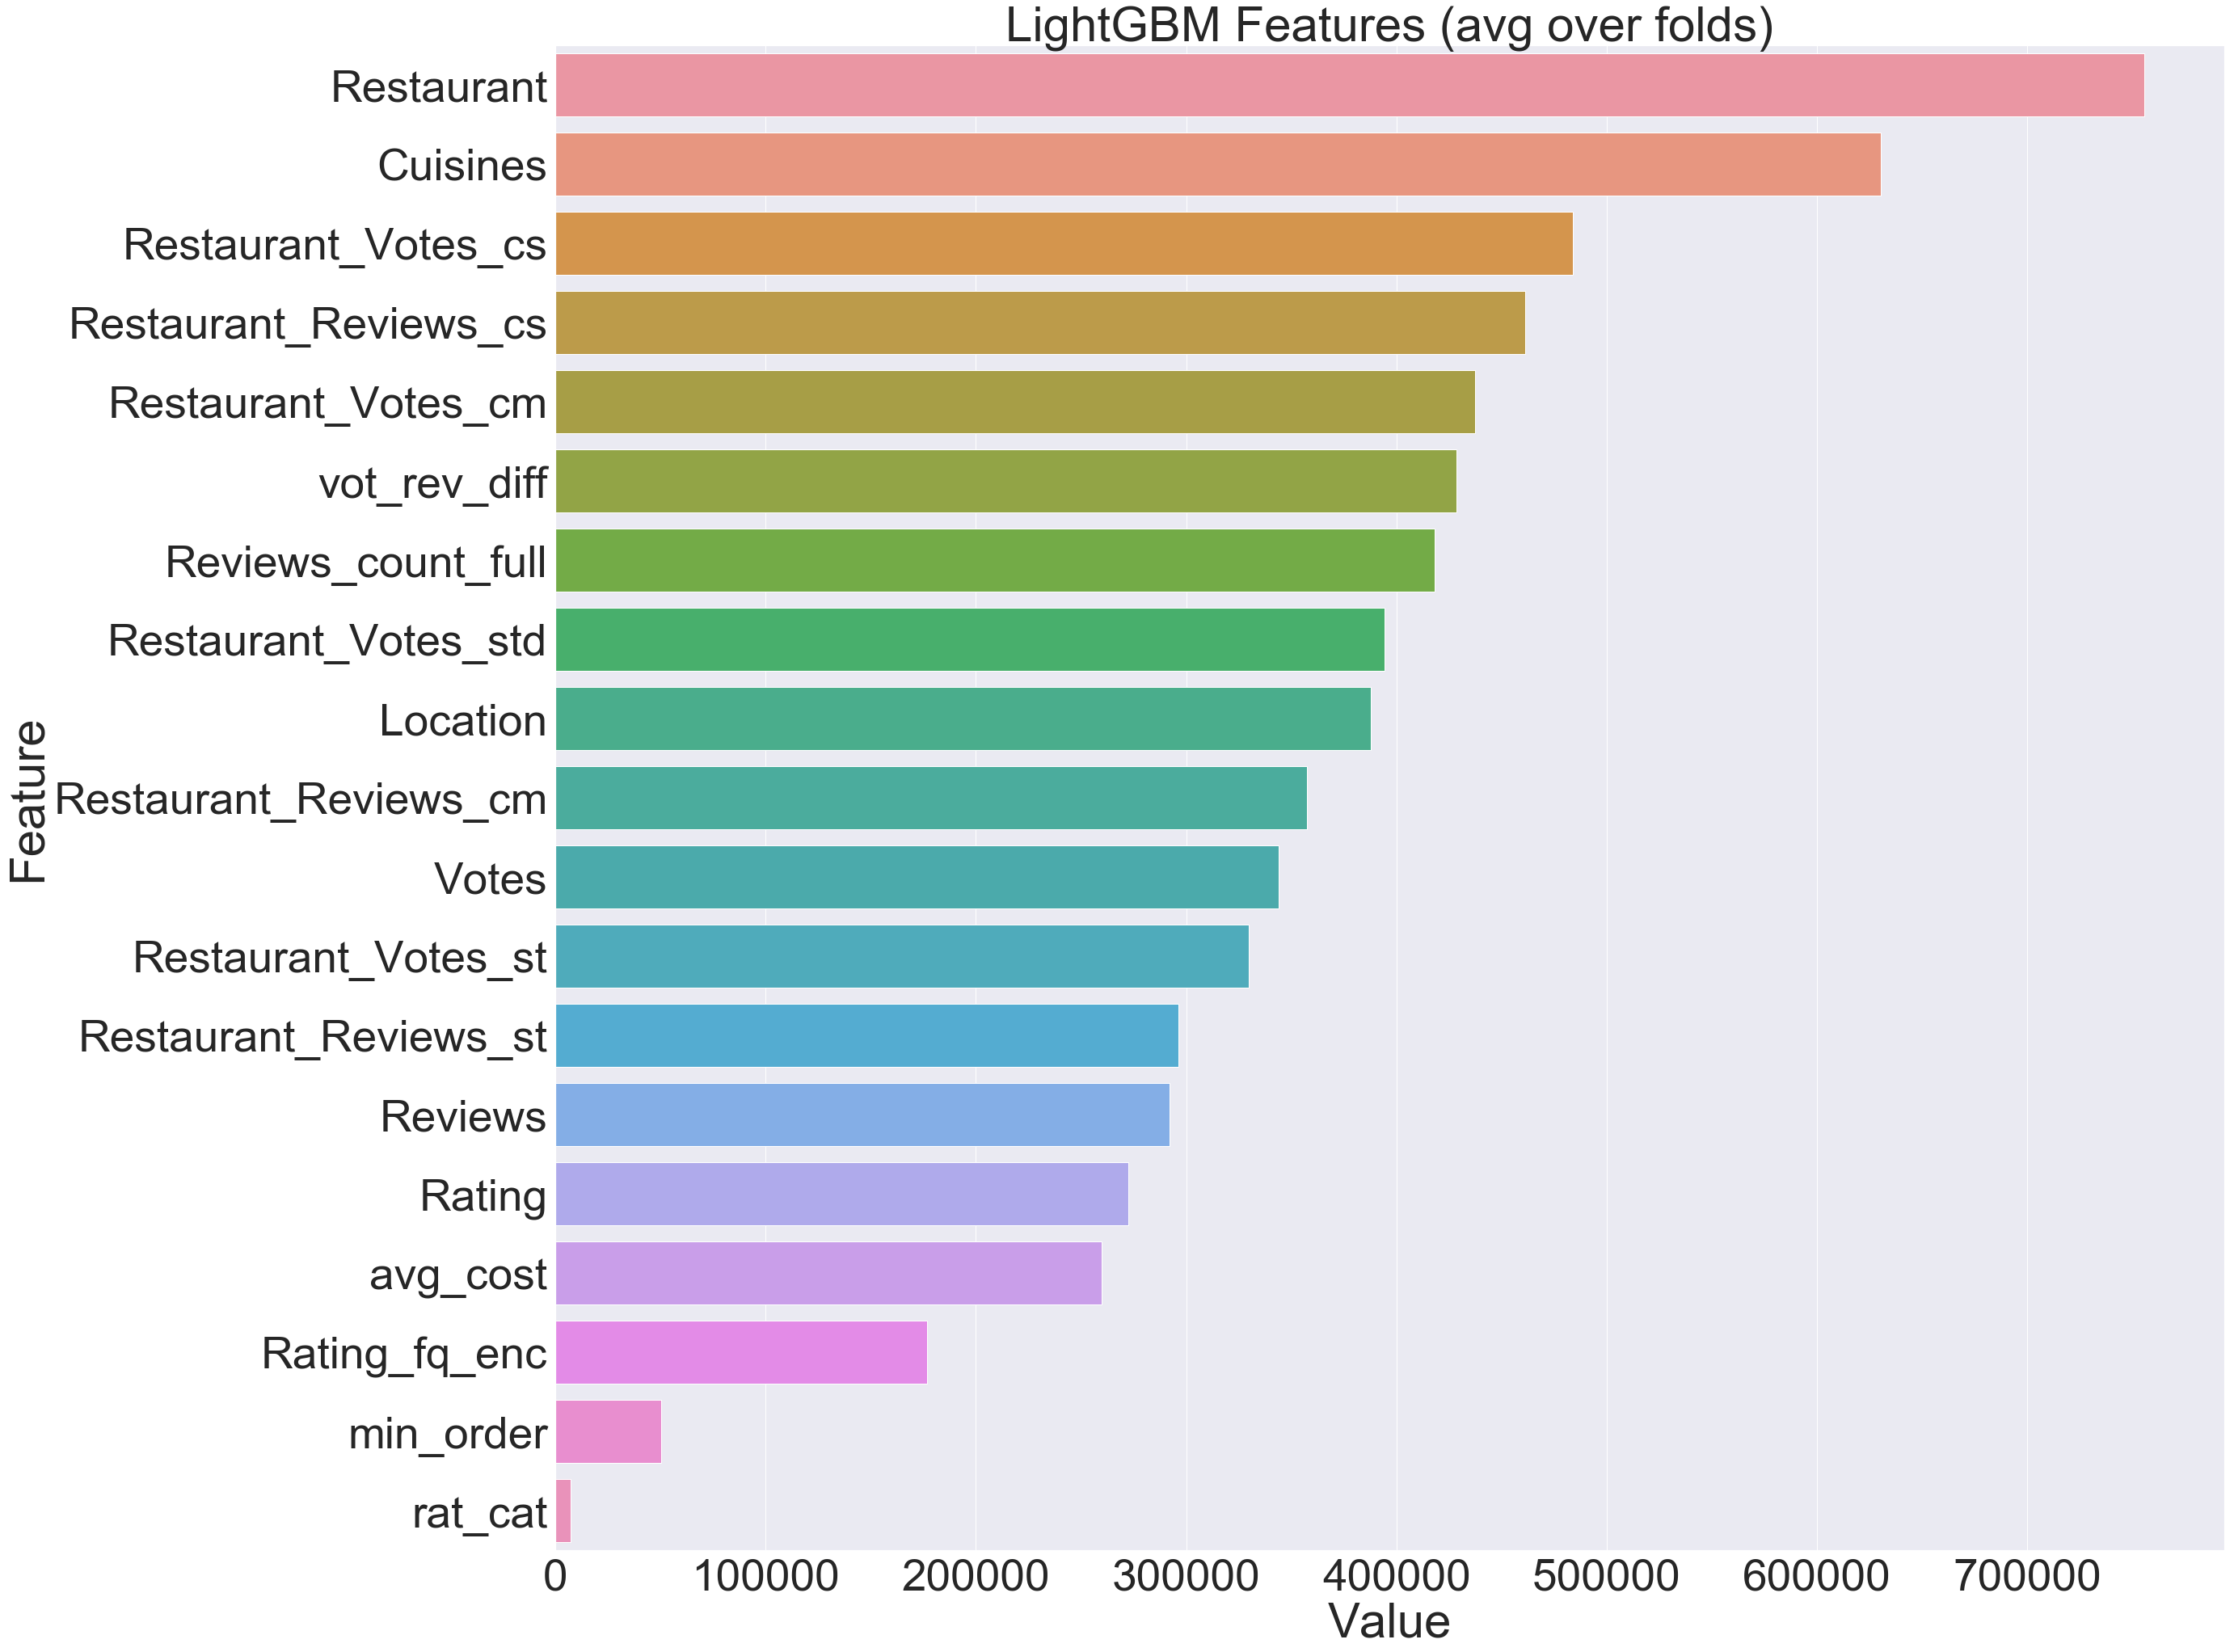

In [440]:
plotImp(gbm,X_train)

In [464]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

Starting predicting...


In [465]:
y_pred[0:5,:]

array([[2.23703675e-05, 1.10417162e-04, 7.01002994e-01, 2.66717298e-01,
        3.17669514e-02, 6.72094894e-05, 3.12759404e-04],
       [6.08141173e-06, 2.73220380e-05, 9.79305755e-01, 1.89148458e-02,
        1.63190598e-03, 1.82374006e-05, 9.58526088e-05],
       [1.15455750e-05, 4.31220765e-05, 9.49949370e-01, 4.25712649e-02,
        7.25417770e-03, 2.85967107e-05, 1.41922779e-04],
       [1.47629418e-05, 6.63488865e-05, 9.16280530e-01, 6.63381857e-02,
        1.70412486e-02, 5.23260792e-05, 2.06597772e-04],
       [2.46086843e-05, 1.48814620e-04, 8.43131010e-01, 1.09684205e-01,
        4.65662751e-02, 7.37647237e-05, 3.71321925e-04]])

In [466]:
predictions = []

for x in y_pred:
    predictions.append(np.argmax(x))


In [467]:
sample.Delivery_Time = predictions
sample.head(10)

,Delivery_Time
0,2
1,2
2,2
3,2
4,2
5,2
6,2
7,2
8,2
9,2


In [468]:
#y_pred = y_preds.astype(int)

In [469]:
#sample.Delivery_Time = y_pred
#sample.head(10)

In [470]:
sample['Delivery_Time'] = sample.Delivery_Time.astype(str)

In [471]:
sample.Delivery_Time = sample['Delivery_Time'].map( {'0':'10 minutes', '1':'20 minutes','2':'30 minutes','3':'45 minutes','4':'65 minutes','5':'80 minutes','6':'120 minutes'} ).astype(str)

In [472]:
sample.head()

,Delivery_Time
0,30 minutes
1,30 minutes
2,30 minutes
3,30 minutes
4,30 minutes


In [473]:
sample.to_excel(r'C:\Users\Ashish\Desktop\Data Science A-Z\Food Delivery\Participants Data\Sample_lgb5.xlsx', index=False)